In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [2]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 


import numpy as np
import scipy.ndimage


import sys
sys.path.append('../scripts')
import load_utils
import watereshed
import generator_3D

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}

In [11]:
def rot(image, xy, angle, reshape=True):
    im_rot = scipy.ndimage.interpolation.rotate(image, angle, reshape=reshape) 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    org = xy - org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a)])
    return im_rot, new + rot_center

In [12]:
def slice_along(arr, ids, axis):
    arr = np.swapaxes(arr, axis, 0)
    arr = arr[slice(*ids)]
    return np.swapaxes(arr, axis, 0)

In [13]:
def process(patient_id):    
    patient, meta = load_utils.load_patient(PATHS['DATA'], patient_id, metadata=True)


    meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*_A.stl'))
    meshs = load_utils.load_mesh(meshs[0], meta) 


#     if patient[:10].mean() > patient[-10:].mean():
#         patient = np.flip(patient, 0)
#         meshs = np.flip(meshs, 0)
        
    bbox = np.array(np.where(meshs))
    bbox = np.array([bbox.min(1), bbox.max(1)])
    bbox_shape = (np.diff(bbox, axis=0) * 3).astype(np.int).flatten()
    bbox_centroid = bbox.mean(0).astype(np.int)

    bbox_axes = [0]
    
    for bb_axis in bbox_axes:
        bb_ids = (
            bbox_centroid[bb_axis] - bbox_shape[bb_axis] // 2, 
            bbox_centroid[bb_axis] + bbox_shape[bb_axis] // 2
        )
        bb_ids = np.clip(bb_ids, 0, patient.shape[bb_axis])
        meshs = slice_along(meshs, bb_ids, bb_axis)
        patient = slice_along(patient, bb_ids, bb_axis)
    
#     fact = min(1, meta['PixSpac'].mean()) / meta['PixSpac']
    fact = meta['PixSpac']
    
    meshs = scipy.ndimage.zoom(meshs, fact, order=0)
    patient = scipy.ndimage.zoom(patient, fact, order=3)
    
    x, y = np.asarray(np.where(meshs))[[0, 2]]
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    init_d = p.deriv()
    opt = p(init_d.roots)
    flipped = False
    if np.abs(p(x.min()) - opt) > np.abs(p(x.max()) - opt):
        flipped = True
        patient = np.flip(patient, 0)
        meshs = np.flip(meshs, 0)
        x, y = np.asarray(np.where(meshs))[[0, 2]]
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        
    # point = np.random.choice(np.unique(x))
    # a = p(point + 1) - p(point)
    # a = np.tan(np.arctan(a) + np.pi / 2)
    # w = np.poly1d([a, p(point) - a * point])

    # xp = np.linspace(x.min(), x.max(), 100)
    # xw = np.linspace(point - 50, point + 50, 100)


    tangs = list()
    x_unique = np.unique(x)
    summedx = meshs.sum(1)
    for point in x_unique:
        a = p(point + 1) - p(point)
        a = np.tan(np.arctan(a) + np.pi / 2)
        w = np.poly1d([a, p(point) - a * point])

        length = int(np.hypot(p(point - 100) - p(point + 100), 200))
        xw = np.linspace(point - 100, point + 100, length)
        #x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(summedx, np.vstack((xw, w(xw))))
        tangs.append(zi.sum())

    tangs = np.array(tangs)
    tangs = scipy.ndimage.gaussian_filter1d(tangs, 5)
    args = scipy.signal.argrelextrema(tangs, np.greater_equal, order=4, mode='wrap')[0]
    args = args[tangs[args] != 0]
    args = np.array([args[0]] + args[1:][np.diff(args) > 2].tolist())
    
    init_p = p
    patches = np.zeros((len(args), patient.shape[1], patient.shape[2], 2))
    for num, point in enumerate(x_unique[args]):
        angle = np.arctan(init_p(point) - init_p(point + 1))
        angle *= 180 / np.pi
        angle = np.round(angle)
        rotated, rpoint = rot(summedx, np.array([init_p(point), point]), angle, False)


        mes = scipy.ndimage.interpolation.rotate(meshs[:, :patient.shape[1], :patient.shape[2]], 
                                                 angle, (0, 2), order=0, reshape=False)
        pat = scipy.ndimage.interpolation.rotate(patient, angle, (0, 2), reshape=False)

        x, y = np.asarray(np.where(mes))[[0, 1]]
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        xp = np.linspace(x.min(), x.max(), 100)

        angle = np.arctan(p(x.max()) - p(x.max() + 1))
        angle *= 180 / np.pi
        angle = np.round(angle)
        rotated, rpoint = rot(mes.sum(2), np.array([p(rpoint[1]), rpoint[1]]), angle, reshape=False)


        mes = scipy.ndimage.interpolation.rotate(mes[:, :pat.shape[1], :pat.shape[2]], 
                                                 angle, (0, 1), order=0, reshape=False)
        pat = scipy.ndimage.interpolation.rotate(pat, angle, (0, 1), reshape=False)

        i = min(len(pat) - 1, int(rpoint[1]))
        patches[num] = np.dstack([pat[i], mes[i, :pat.shape[1], :pat.shape[2]]])
    np.save(os.path.join(PATHS['DATA'], patient_id, 'patch'), patches)
    
    meta['patient_id'] = patient_id
    meta['shape'] = patient.shape
    meta['picks'] = len(args)
    meta['is_flipped'] = flipped
    
    return meta

In [8]:
processeds = pickle.load(open(os.path.join(PATHS['DATA'], 'processed_meta.pkl'), 'rb'))

In [14]:
from multiprocessing import Pool
import h5py
import uuid
import pickle


BATCH_SIZE = 10

patient_ids = glob(os.path.join(PATHS['DATA'], '*'))
patient_ids = [os.path.basename(pid) for pid in patient_ids if len(os.path.basename(pid)) == 9]

processeds = list()
for i in tqdm(range(len(patient_ids) // BATCH_SIZE + 1)):
    batch = patient_ids[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    with Pool(4) as pool:
        processed = pool.map(process, batch)
#     processed = np.concatenate(processed)
    processeds.extend(processed)
    pickle.dump(processeds, open(os.path.join(PATHS['DATA'], 'processed_meta.pkl'), 'wb'))

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

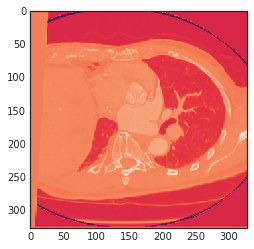

In [15]:
plt.imshow(patches[1][..., 0])

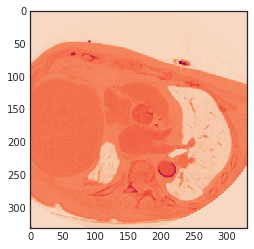

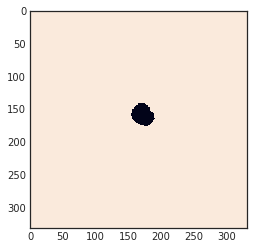

In [37]:
i = 0
# s = 0
plt.imshow(-(patch[s][ ..., 0]))
plt.show()
plt.imshow(-(patch[s][ ..., 1]))
plt.show()

In [104]:
patient_id = '0262R3009'
patient, meta = load_utils.load_patient(PATHS['DATA'], patient_id, metadata=True)


meshs = glob(os.path.join(PATHS['DATA'], patient_id, '*_A.stl'))
meshs = load_utils.load_mesh(meshs[0], meta) 


if patient[:10].mean() > patient[-10:].mean():
    patient = np.flip(patient, 0)
    meshs = np.flip(meshs, 0)

bbox = np.array(np.where(meshs))
bbox = np.array([bbox.min(1), bbox.max(1)])
bbox_shape = (np.diff(bbox, axis=0) * (3 ** .5)).astype(np.int).flatten()
bbox_centroid = bbox.mean(0).astype(np.int)

bbox_axes = [0]
for bb_axis in bbox_axes:
    bb_ids = (
        bbox_centroid[bb_axis] - bbox_shape[bb_axis] // 2, 
        bbox_centroid[bb_axis] + bbox_shape[bb_axis] // 2
    )
    meshs = slice_along(meshs, bb_ids, bb_axis)
    patient = slice_along(patient, bb_ids, bb_axis)

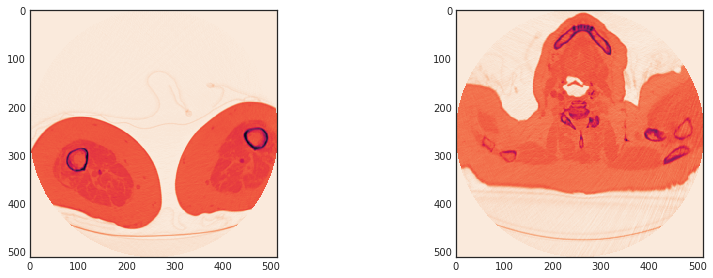

In [9]:
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.imshow(-(patient[40]))
plt.subplot(222)
plt.imshow(-(patient[-10]))

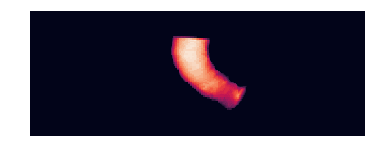

In [105]:
summedx = meshs.sum(1)
plt.imshow(summedx)

x, y = np.asarray(np.where(meshs))[[0, 2]]
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

point = np.random.choice(np.unique(x))
a = p(point + 1) - p(point)
a = np.tan(np.arctan(a) + np.pi / 2)
w = np.poly1d([a, p(point) - a * point])

xp = np.linspace(x.min(), x.max(), 100)
xw = np.linspace(point - 50, point + 50, 100)
# plt.plot(p(xp), xp, '-');
# plt.plot(w(xw), xw, '-');
# plt.scatter(p(point), point)
plt.axis('off');

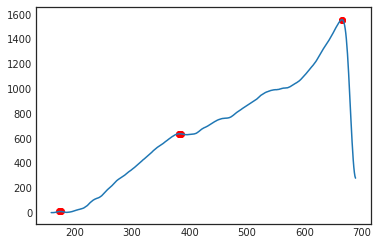

In [142]:
tangs = list()
x_unique = np.unique(x)
for point in x_unique:
    a = p(point + 1) - p(point)
    a = np.tan(np.arctan(a) + np.pi / 2)
    w = np.poly1d([a, p(point) - a * point])
    
    length = int(np.hypot(p(point - 100) - p(point + 100), 200))
    xw = np.linspace(point - 100, point + 100, length)
    #x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
    # Extract the values along the line, using cubic interpolation
    zi = scipy.ndimage.map_coordinates(summedx, np.vstack((xw, w(xw))))
    tangs.append(zi.sum())

tangs = np.array(tangs)
tangs = scipy.ndimage.gaussian_filter1d(tangs, 5)
args = scipy.signal.argrelextrema(tangs, np.greater_equal, order=4, mode='wrap')[0]
args = args[tangs[args] != 0]

plt.plot(x_unique, tangs)
plt.scatter(x_unique[args], tangs[args], c='r')
plt.show()

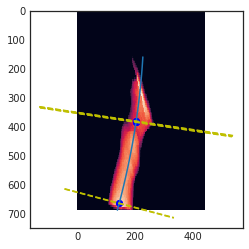

In [125]:
init_p = p
plt.imshow(summedx)
plt.plot(init_p(xp), xp, '-');
for point in x_unique[args].tolist():
    
    a = init_p(point + 1) - init_p(point)
    a = np.tan(np.arctan(a) + np.pi / 2)
    w = np.poly1d([a, init_p(point) - a * point])

    xp = np.linspace(x.min(), x.max(), 100)
    xw = np.linspace(point - 50, point + 50, 100)
    
    plt.plot(w(xw), xw, '--', c='y');
    plt.scatter(init_p(point), point, c='b')

# plt.axis('off');

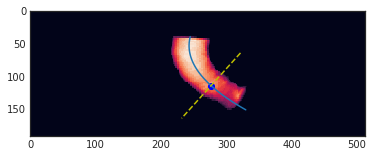

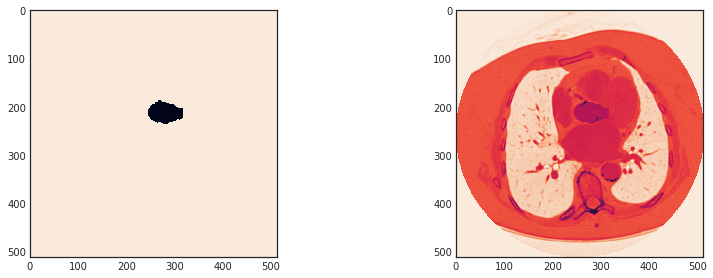

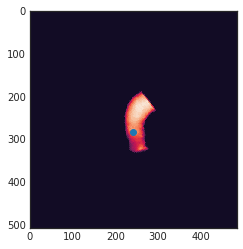

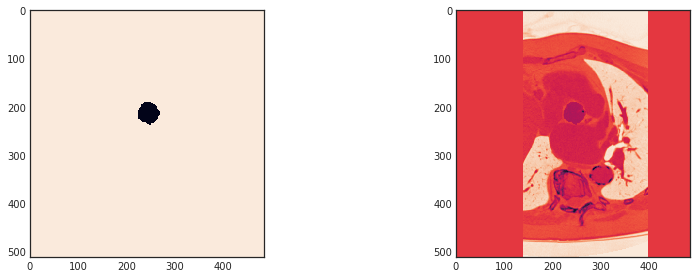

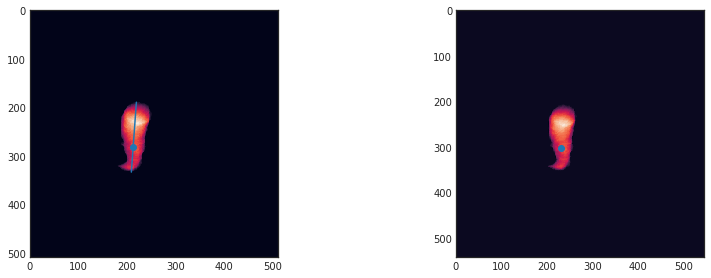

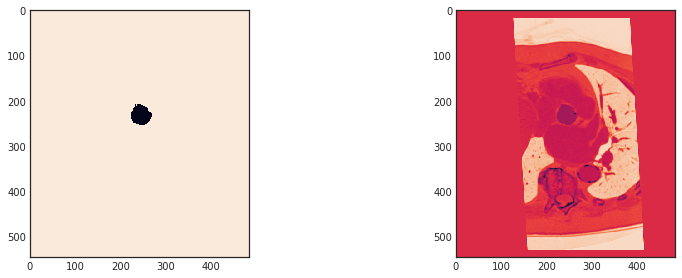

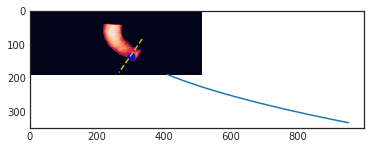

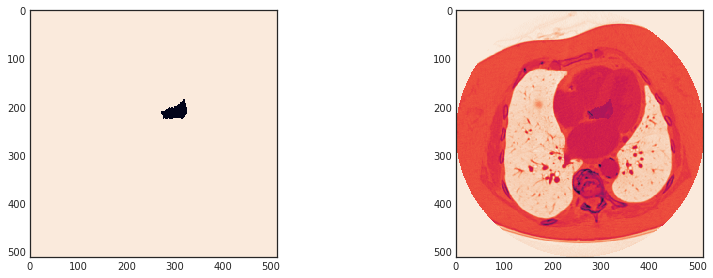

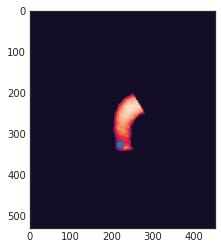

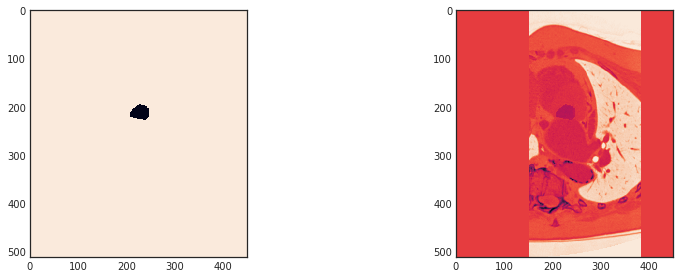

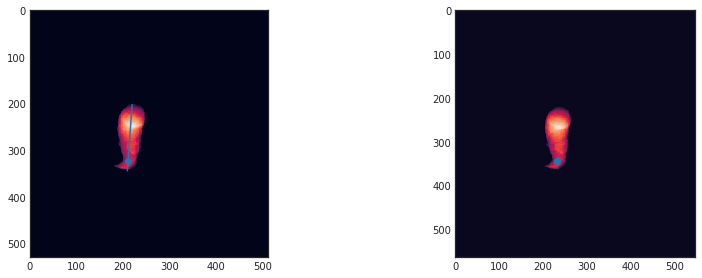

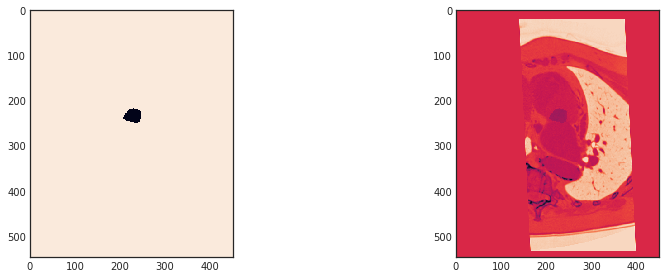

In [109]:
init_p = p
for point in x_unique[args].tolist():
    plt.imshow(summedx)
    plt.plot(init_p(xp), xp, '-');
    a = init_p(point + 1) - init_p(point)
    a = np.tan(np.arctan(a) + np.pi / 2)
    w = np.poly1d([a, init_p(point) - a * point])

    xp = np.linspace(x.min(), x.max(), 100)
    xw = np.linspace(point - 50, point + 50, 100)
    
    plt.plot(w(xw), xw, '--', c='y');
    plt.scatter(init_p(point), point, c='b')
    plt.show()
    
    i = int(point)
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow(~meshs[i])
    plt.subplot(222)
    plt.imshow(-(patient[i] + 200 * meshs[i, :patient.shape[1], :patient.shape[2]]))
    plt.show()


    angle = np.arctan(init_p(point) - init_p(point + 1))
    angle *= 180 / np.pi
    angle = np.round(angle)

    rotated, rpoint = rot(summedx, np.array([init_p(point), point]), angle)    
    mes = scipy.ndimage.interpolation.rotate(meshs[:, :patient.shape[1], :patient.shape[2]], 
                                             angle, (0, 2), mode='nearest', order=0)
    pat = scipy.ndimage.interpolation.rotate(patient, angle, (0, 2))
    
    # rpoint -= (np.array(rotated.shape) - np.array(summedx.shape)) // 2
    
    plt.imshow(rotated)
    plt.scatter(rpoint[0], rpoint[1])
    plt.show()
    
    i = int(rpoint[1])
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow(~mes[i])
    plt.subplot(222)
    plt.imshow(-(pat[i] + 200 * mes[i, :pat.shape[1], :pat.shape[2]]))


    summedy = mes.sum(2)
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow(summedy)
    x, y = np.asarray(np.where(mes))[[0, 1]]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xp = np.linspace(x.min(), x.max(), 100)

    angle = np.arctan(p(x.max()) - p(x.max() + 1))
    angle *= 180 / np.pi
    angle = np.round(angle)

    plt.plot(p(xp), xp, '-');
    plt.scatter(p(rpoint[1]), rpoint[1])
    plt.subplot(222)
    rotated, rpoint = rot(summedy, np.array([p(rpoint[1]), rpoint[1]]), angle)
    plt.imshow(rotated)
    plt.scatter(rpoint[0], rpoint[1])
    plt.show()


    mes = scipy.ndimage.interpolation.rotate(mes[:, :pat.shape[1], :pat.shape[2]], 
                                             angle, (0, 1), mode='nearest', order=0)
    pat = scipy.ndimage.interpolation.rotate(pat, angle, (0, 1))


    i = int(rpoint[1])
    plt.figure(figsize=(14, 10))
    plt.subplot(221)
    plt.imshow(~mes[i])
    plt.subplot(222)
    plt.imshow(-(pat[i] + 200 * mes[i, :pat.shape[1], :pat.shape[2]]))
    plt.show()

In [ ]:
import pandas as pd
from glob import glob

df = pd.read_excel('/home/ubuntu/cdata/DM_Data/REPRISE III Sizes.xlsx')
df['Valve Size (Model number)'].value_counts()

In [ ]:
croped = []
segmented = []
for i in tqdm(range(len(patient))):
    s, w = seperate_lungs(patient[i])
    croped.append(s)
    segmented.append(w)

croped = np.array(croped)
segmented = np.array(segmented)